In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
!pip install text-preprocessing

/kaggle/input/imdb-spoiler-dataset/IMDB_movie_details.json
/kaggle/input/imdb-spoiler-dataset/IMDB_reviews.json
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.200d.txt
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.50d.txt
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.300d.txt
/kaggle/input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.100d.txt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 MB 13.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 70.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 21.6 MB/s eta 0:00:00
  Created wheel for names-dataset: filename=names_dataset-3.1.0-py3-none-any.whl size=116832781 sha256=16c233e1af808e737b67ed16685e0726cfc792fa15ae50af58a31890f6df09bd
  Sto

In [2]:
# regular expression and string case
import re
import string

# Data reading
import pandas as pd
import numpy as np

# tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds

# Sklearn
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from text_preprocessing import preprocess_text
from sklearn.model_selection import train_test_split
from text_preprocessing import to_lower, remove_email, remove_url, remove_punctuation, lemmatize_word,remove_stopword,remove_number

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read the dataset
df_reviews = pd.read_json('../input/imdb-spoiler-dataset/IMDB_reviews.json', lines=True)
df_details = pd.read_json('../input/imdb-spoiler-dataset/IMDB_movie_details.json',lines =True)

In [4]:
#Function to get a equal number of data from both classification
def get_part_data(df, num_reviews):
    
    num_pos_reviews = df[df["is_spoiler"]== True].shape[0]  # Number of spoilers in the dataset
    num_neg_reviews = df[df["is_spoiler"]== False].shape[0] # Number of Non-spoilers in the dataset
    
    fraction_pos = num_reviews/num_pos_reviews  # fraction of spoiler reviews to be returned
    fraction_neg = num_reviews/num_neg_reviews  # fraction of non-spoiler reviews to be returned 

    df_pos = df[df['is_spoiler'] == True].sample(frac = fraction_pos, random_state = 2)
    df_neg = df[df['is_spoiler'] == False].sample(frac = fraction_neg, random_state = 2)

    df_re = pd.concat([df_pos, df_neg])  # join the True and False dataset
    df_re = df_re.reset_index(drop=True)  # mix the index values
    df_re.loc[(df_re['is_spoiler'] == True) ,'is_spoiler'] =1
    df_re.loc[(df_re['is_spoiler'] == False) ,'is_spoiler'] =0
    return df_re[["movie_id","review_text","review_summary","is_spoiler"]]

# Cummulation of stopwords
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]


# Removing the stop word and tags
def remove_stopwords(data):
    data['review_ws'] = data['review_text'].apply(lambda x :' '.join([word for word in x.split() 
                                                                 if word not in (stopwords)]))
    return data

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result

In [5]:
old_data = get_part_data(df_reviews, 110000)

In [6]:
# Preprocess text using custom preprocess functions in the pipeline
preprocess_functions = [to_lower, remove_email, remove_url, remove_punctuation,remove_stopword, lemmatize_word]
old_data['clean_review'] = old_data['review_text'].apply(lambda x : preprocess_text(x,preprocess_functions))

In [7]:
old_data['clean_review'].iloc[0]

'overall movie simply excellent one pixars finest 100 worth watchinggood movie contains absolutely gorgeous animation rich detail care outstanding every frame much care passion implemented truly sensational spectacle behold story beautifully woven emotionally charged character interesting likable villain conniving cruel easily hateable relationship hero also great choice doug personal favourite character charm love wit could ever ask dog russell quirky funny help adore polar opposite mr frederickson however cold harsh even ruthless see goodness inside feel really sorry magnificent ending perfectly fit make grown man cry typical pixar fashion music beautiful intricately designed chosen perfect scene movie make laugh make cry keep edge seat make exclaim amazement pixar masterpiecebad sound like world biggest jerk refuse believe chubby kid frail old man keep house enough balloon attached make fly ground animation liberty made annoyed slightlybest part beautiful endingmvp ed asnerjeremy le

In [8]:
# label encoder used to tranform the labels
le = LabelEncoder()

# train and test split
training_reviews,testing_reviews,training_labels,testing_labels  = train_test_split(old_data['clean_review'].values,old_data['is_spoiler'].values,test_size = 0.30)
training_labels = le.fit_transform(training_labels)
testing_labels = le.fit_transform(testing_labels)

In [9]:
# Shape of train and test data
print(training_reviews.shape)
print(testing_reviews.shape)

(154000,)
(66000,)


In [10]:
# Tokenize the text 
tokenizer = Tokenizer(num_words=10000,oov_token='<OOV>')
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_reviews)
testing_sequence = tokenizer.texts_to_sequences(testing_reviews)

# covert the text into padded sequence
train_pad_sequence = pad_sequences(training_sequence,maxlen = 400,truncating= 'post',padding = 'pre')
test_pad_sequence = pad_sequences(testing_sequence,maxlen = 400,truncating= 'post',padding = 'pre')
print('Total Unique Words : {}'.format(len(word_index)))

Total Unique Words : 469561


In [11]:
from gensim.models import KeyedVectors
filename = '../input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin'
w2v_pretrained_model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [12]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1,300))
for word,i in tqdm(tokenizer.word_index.items()):
    try:
        embedding_value = w2v_pretrained_model[word]
        if embedding_value is not None:
            embedding_matrix[i] = embedding_value         
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),300)  

100%|██████████| 469561/469561 [00:12<00:00, 37039.01it/s]


In [13]:
print(train_pad_sequence.shape)
print(test_pad_sequence.shape)
print(embedding_matrix.shape)

(154000, 400)
(66000, 400)
(469562, 300)


# Using Word2vec embedding with Bi-LSTM layer

layer1: Embedding Layer using word2vec weights

layer2: Using a Bidirectional LSTM

layer3: A dropout Layer

layer4: A Dense layer of 256 neurons with 'relu' activation

layer5: A Dense Layer of 128 neurons with 'relu' activation

layer6: Again a dropout layer.

layer7: Sigmoid activation layer to classify it positive and negative.

In [14]:
# Built the Bi-LSTM model using tensorflow.keras
model = tf.keras.Sequential([tf.keras.layers.Embedding(len(word_index) + 1,300,weights=[embedding_matrix],input_length=300,
                            trainable=False),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(256,activation = 'relu',),
                             tf.keras.layers.Dense(128,activation = 'relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1,activation = tf.nn.sigmoid)])
model.summary()

2022-08-23 11:54:06.447859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 11:54:06.598378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 11:54:06.599144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 11:54:06.601799: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          140868600 
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               186880    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [15]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy() , optimizer='Adam' , metrics = 'accuracy')
history = model.fit(train_pad_sequence,training_labels,epochs = 10 ,validation_data=(test_pad_sequence,testing_labels))

Epoch 1/10


2022-08-23 11:54:11.077182: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-23 11:54:14.694289: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4813/4813 [==============================] - ETA: 0s - loss: 0.6834 - accuracy: 0.5454

2022-08-23 11:56:51.943585: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 105600000 exceeds 10% of free system memory.


4813/4813 [==============================] - 189s 38ms/step - loss: 0.6834 - accuracy: 0.5454 - val_loss: 0.6503 - val_accuracy: 0.6080
Epoch 2/10
4813/4813 [==============================] - 185s 39ms/step - loss: 0.6229 - accuracy: 0.6567 - val_loss: 0.5999 - val_accuracy: 0.6737
Epoch 3/10
4813/4813 [==============================] - 185s 39ms/step - loss: 0.5915 - accuracy: 0.6855 - val_loss: 0.5812 - val_accuracy: 0.6880
Epoch 4/10
4813/4813 [==============================] - 185s 39ms/step - loss: 0.5809 - accuracy: 0.6944 - val_loss: 0.5827 - val_accuracy: 0.6921
Epoch 5/10
4813/4813 [==============================] - 185s 38ms/step - loss: 0.5719 - accuracy: 0.7004 - val_loss: 0.5779 - val_accuracy: 0.6941
Epoch 6/10
4813/4813 [==============================] - 184s 38ms/step - loss: 0.5635 - accuracy: 0.7070 - val_loss: 0.5746 - val_accuracy: 0.6939
Epoch 7/10
4813/4813 [==============================] - 184s 38ms/step - loss: 0.5549 - accuracy: 0.7126 - val_loss: 0.5795 - val

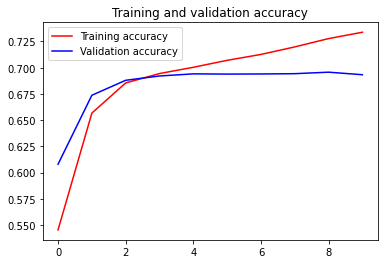

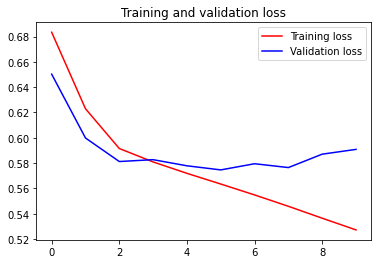

In [16]:
# Evaluate the model using accuracy and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [17]:
print('Training Accuracy: {}'.format(max(acc)))
print('Validation Accuracy: {}'.format(max(val_acc)))

Training Accuracy: 0.7337856888771057
Validation Accuracy: 0.6957272887229919


In [18]:
predictions = (model.predict(test_pad_sequence) > 0.5).astype("int32")
# Evaluation report
from sklearn.metrics import classification_report
report = classification_report(testing_labels,predictions)
print(report)

2022-08-23 12:25:01.663319: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 105600000 exceeds 10% of free system memory.


              precision    recall  f1-score   support

           0       0.68      0.74      0.71     32974
           1       0.72      0.64      0.68     33026

    accuracy                           0.69     66000
   macro avg       0.70      0.69      0.69     66000
weighted avg       0.70      0.69      0.69     66000



In [20]:
import sklearn.metrics as metrics

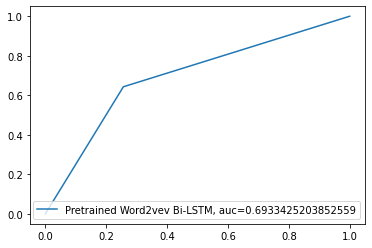

In [22]:
fpr, tpr, _ = metrics.roc_curve(testing_labels,  predictions)
auc = metrics.roc_auc_score(testing_labels, predictions)
plt.plot(fpr,tpr,label="Pretrained Word2vev Bi-LSTM, auc="+str(auc))
plt.legend(loc=4)
plt.show()